In [1]:
%load_ext autoreload

In [2]:
import os as _os
_os.chdir(_os.environ['PROJECT_ROOT'])
_os.path.realpath(_os.path.curdir)

'/pollard/home/bsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess
from itertools import chain
import os

In [4]:
import sfacts as sf

/pollard/home/bsmith/.snakemake/conda/94b3294f3bfcd649af97bd849d201220_/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import lib.thisproject.data

In [6]:
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 50

In [7]:
group = 'hmp2'
species = '102506'
stemA = 'r.proc'
stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s85-seed0'
spgc_params = 'e100'
centroid = 95

path = dict(
    flag=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.midas_gene{centroid}.spgc-{spgc_params}.strain_files.flag",
    fit=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.world.nc",
    strain_correlation=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.midas_gene{centroid}.spgc-{spgc_params}.strain_correlation.tsv",
    strain_depth_ratio=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.midas_gene{centroid}.spgc-{spgc_params}.strain_depth_ratio.tsv",
    strain_fraction=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.comm.tsv",
    species_gene_mean_depth=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.midas_gene{centroid}.spgc-{spgc_params}.species_depth.tsv",
    species_gtpro_depth=f"data/group/{group}/{stemA}.gtpro.species_depth.tsv",
    species_correlation=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.midas_gene{centroid}.spgc-{spgc_params}.species_correlation.tsv",
    strain_thresholds=f"data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.midas_gene{centroid}.spgc-{spgc_params}.strain_gene_threshold.tsv",
    gene_annotations=f"ref/midasdb_uhgg_gene_annotations/sp-{species}.gene{centroid}_annotations.tsv",
    raw_gene_depth=f"data/group/{group}/species/sp-{species}/{stemA}.midas_gene{centroid}.depth.nc",
    reference_copy_number=f"ref/midasdb_uhgg_pangenomes/{species}/midas_gene{centroid}.reference_copy_number.nc",
    cluster_info=f"ref/midasdb_uhgg/pangenomes/{species}/cluster_info.txt",
    species_taxonomy="ref/gtpro/species_taxonomy_ext.tsv",
    midasdb_genomes="ref/uhgg_genomes_all_4644.tsv",
    gtpro_reference_genotype=f"data/species/sp-{species}/gtpro_ref.mgtp.nc"
)

path_exists = {}
for p in path:
    path_exists[path[p]] = os.path.exists(path[p])

assert all(path_exists.values()), [p for p in path_exists if not path_exists[p]]

In [8]:
species_taxonomy = lib.thisproject.data.load_species_taxonomy(path["species_taxonomy"])
species_taxonomy.loc[species]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

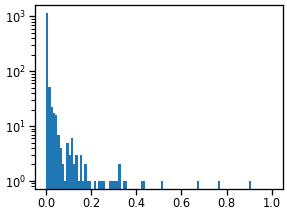

In [9]:
all_species_gtpro_depth = lib.thisproject.data.load_species_depth(path["species_gtpro_depth"])
all_species_gtpro_rabund = all_species_gtpro_depth.divide(all_species_gtpro_depth.sum(1), axis=0) 

plt.hist(all_species_gtpro_rabund[species], bins=np.linspace(0, 1, num=101))
plt.yscale('log')
None

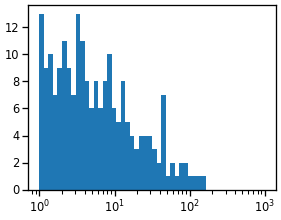

In [10]:
plt.hist(all_species_gtpro_depth[species], bins=np.logspace(0, 3, num=51))
plt.xscale('log')
None

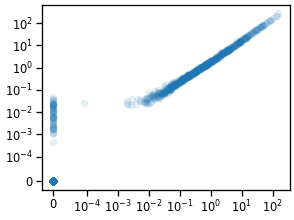

In [11]:
focal_species_core_depth = lib.thisproject.data.load_single_species_depth(path["species_gene_mean_depth"])

d = pd.DataFrame(dict(
    gtpro=all_species_gtpro_depth[species],
    gene=focal_species_core_depth,
))

plt.scatter('gtpro', 'gene', data=d, alpha=0.1)
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)
None

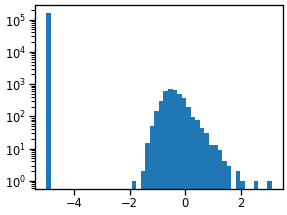

In [12]:
gene_depth = xr.load_dataarray(path["raw_gene_depth"])

plt.hist(np.log10(gene_depth.isel(sample=0) + 1e-5), bins=50)
plt.yscale('log')
None

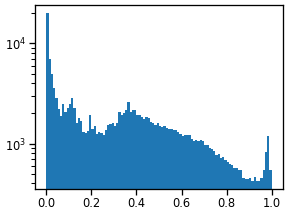

In [13]:
species_corr = pd.read_table(path["species_correlation"], names=['sample', 'correlation'], index_col='sample').squeeze()
plt.hist(species_corr, bins=np.linspace(0, 1, num=101))
plt.yscale('log')
None

In [14]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')
subject = pd.read_table('meta/hmp2/subject.tsv', index_col='subject_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').join(subject, on='subject_id').loc[all_species_gtpro_depth.index]

In [15]:
species_depth = pd.read_table(path["species_gene_mean_depth"], names=['sample', 'depth'], index_col='sample').squeeze()

In [16]:
fit = sf.World.load(
    f'data/group/{group}/species/sp-{species}/{stemA}.gtpro.{stemB}.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
position_ss = fit.random_sample(position=min(fit.sizes['position'], 1000)).position

Frozen({'strain': 147, 'position': 10000, 'sample': 624, 'allele': 2})


In [17]:
ref_geno = sf.Genotype(
    sf.data.Metagenotype.load(path["gtpro_reference_genotype"])
    .to_estimated_genotype()
    .to_series()
    .unstack()
    .rename(lambda s: 'UHGG' + s[len('GUT_GENOME'):])
    .stack()
    .to_xarray()
    .sel(position=fit.position)
)

In [18]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
31    88
9     22
61    16
5     15
33    11
dtype: int64

/pollard/home/bsmith/.snakemake/conda/94b3294f3bfcd649af97bd849d201220_/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


18


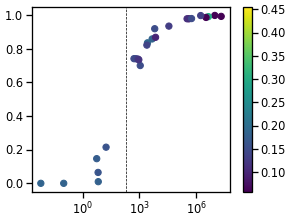

In [19]:
strain_thresholds = (
    pd.read_table(path["strain_thresholds"], index_col='strain')
    .rename(columns=dict(
        correlation_strict='corr_threshold_strict',
        correlation_moderate='corr_threshold_moderate',
        correlation_lenient='corr_threshold_lenient',
        depth_high='depth_thresh_high',
        depth_low='depth_thresh_low',
    ))
)

_strain_meta = (
    strain_thresholds
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(lambda x: x**(3)).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(lambda x: x**(3)).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(lambda x: x**(3)).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: (x.depth_stdev * np.sqrt(x.num_samples)).fillna(0))
)
strain_meta = _strain_meta


power_index_thresh = 200
genotype_entropy_thresh = 0.2

high_power_strain_list = idxwhere((strain_meta.power_index > power_index_thresh) & (strain_meta.genotype_entropy < genotype_entropy_thresh))
print(len(high_power_strain_list))
highest_power_strain_list = strain_meta.sort_values('power_index', ascending=False).head(3).index

plt.scatter(strain_meta.power_index, strain_meta.corr_threshold_moderate, c=strain_meta.genotype_entropy)
plt.axvline(power_index_thresh, lw=1, linestyle='--', color='k')
plt.colorbar()
plt.xscale('log')

In [20]:
strain_meta.assign(high_power=lambda x: x.index.isin(high_power_strain_list)).sort_values('power_index', ascending=False).head(20)

,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index,high_power
strain,,,,,,,,,,,,,
33,0.994768,0.993171,0.988366,0.411627,1.796322,0.057763,0.001486,11,6.252080e+06,2.085262e+07,2.231605e+07,2.073580e+07,True
7,0.999212,0.998745,0.995594,0.422221,1.675251,0.058787,0.003928,5,4.262078e+06,9.530568e+06,9.531659e+06,9.530295e+06,True
13,0.994148,0.991544,0.982987,0.401309,1.674119,0.299153,0.301495,3,2.518416e+06,5.339948e+06,7.811427e+06,4.362024e+06,False
31,0.990680,0.986910,0.976360,0.448925,1.774807,0.058010,0.001639,88,3.495234e+05,3.037484e+06,4.343100e+06,3.278820e+06,True
51,0.998969,0.997999,0.987106,0.413802,1.760547,0.132656,0.040591,2,1.213584e+06,1.716266e+06,1.716266e+06,1.716266e+06,True
52,0.986399,0.980199,0.963169,0.402679,1.779811,0.148784,0.078114,6,2.298364e+05,5.851078e+05,7.713327e+05,5.629818e+05,True
3,0.985062,0.978760,0.959459,0.441493,1.692222,0.074587,0.001964,6,1.674555e+05,4.291857e+05,5.566427e+05,4.101805e+05,True
12,0.986427,0.978952,0.947308,0.383518,1.722686,0.111589,0.015948,5,1.466205e+05,3.351210e+05,4.658228e+05,3.278535e+05,True
63,0.957921,0.935285,0.810186,0.395970,1.849613,0.128564,0.036347,7,1.355466e+04,3.691534e+04,4.797906e+04,3.586227e+04,True


In [21]:
high_power_strain_palette = lib.plot.construct_ordered_palette(high_power_strain_list, mpl.cm.Spectral)

In [22]:
strain_corr = pd.read_table(path["strain_correlation"], index_col=['gene_id', 'strain']).squeeze().unstack('strain', fill_value=0)
strain_depth = pd.read_table(
    path["strain_depth_ratio"],
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [39]:
reference_copy_number = xr.load_dataarray(path["reference_copy_number"])
reference_hit = pd.DataFrame(
    reference_copy_number.T > 0,
    columns=reference_copy_number.genome_id,
    index=reference_copy_number.gene_id,
)

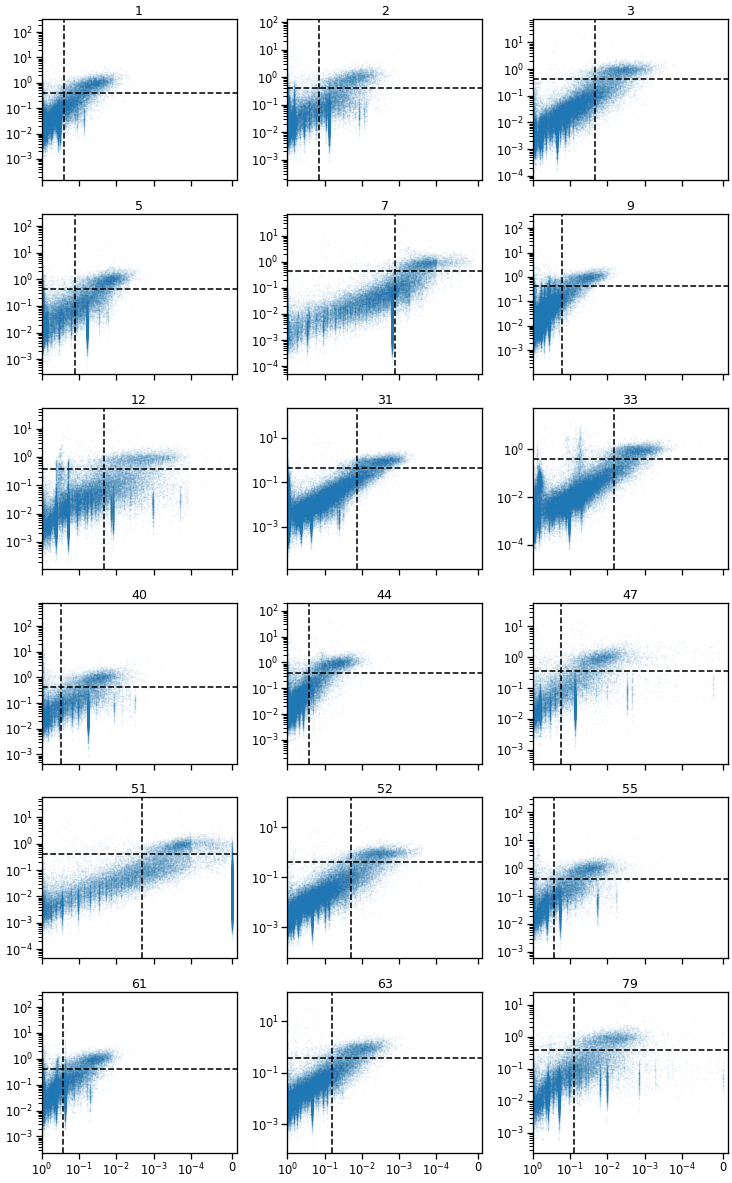

In [34]:
_strain_list = high_power_strain_list

fig, axs = lib.plot.subplots_grid(ncols=3, naxes=len(_strain_list), ax_width=5, ax_height=4, sharex=True)

for strain, ax in zip(_strain_list, axs.flatten()):
    ax.scatter(1 - strain_corr[strain], strain_depth[strain], s=1, alpha=0.05)
    ax.axvline(1 - strain_meta['corr_threshold_moderate'][strain], color='k', linestyle='--')
    ax.axhline(strain_meta['depth_thresh_low'][strain], color='k', linestyle='--')
    ax.set_xscale('symlog', linthresh=1e-4)
    ax.set_xlim(left=-1e-5, right=1)
    ax.invert_xaxis()
    ax.set_yscale('log')
    ax.set_title(strain)
fig.tight_layout()

In [35]:
strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
low_corr =  strain_corr < strain_meta.corr_threshold_lenient

low_depth = (strain_depth < strain_meta.depth_thresh_low)
depth_hit = ~low_depth
high_depth = (strain_depth > strain_meta.depth_thresh_high)
high_confidence_hit = depth_hit & strict_corr_hit
moderate_hit = depth_hit & moderate_corr_hit
maybe_hit = depth_hit & lenient_corr_hit
low_depth_hit = low_depth & strict_corr_hit
high_depth_hit = high_depth & strict_corr_hit
ambiguous_hit = depth_hit ^ strict_corr_hit
high_confidence_not_hit = low_depth & low_corr

/tmp/bsmith/ipykernel_33391/922024519.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
/tmp/bsmith/ipykernel_33391/922024519.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
/tmp/bsmith/ipykernel_33391/922024519.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  moderate_corr_hit = strain_corr > strain_meta.corr_threshold_moderate
/tmp/bs

,tally_moderate_hits,sum_gene_ratio,ratio
strain,,,
12,4133,3583.150451,0.866961
79,4592,4039.874357,0.879764
51,4433,3921.952199,0.884717
63,4702,4249.131583,0.903686
3,4468,4093.995911,0.916293
52,4737,4397.418917,0.928313
2,4419,4104.965013,0.928935
61,5241,4911.438668,0.937119
9,4200,3939.400390,0.937952


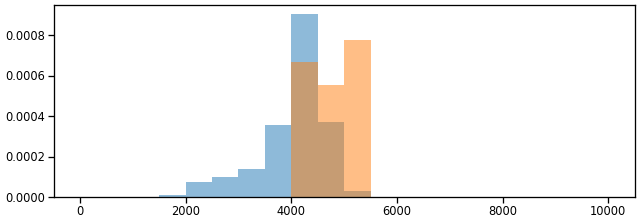

In [84]:
d = pd.DataFrame(dict(
    tally_moderate_hits=moderate_hit.sum(),
    sum_gene_ratio=strain_depth[moderate_hit].sum(),
)).assign(ratio=lambda x: x.sum_gene_ratio / x.tally_moderate_hits)

fig, ax = plt.subplots(figsize=(15, 5))
bins = np.linspace(0, 10000, num=21)
# sns.kdeplot(reference_hit.sum())
# sns.kdeplot(d.tally_moderate_hits)
# sns.kdeplot(d.tally_moderate_hits.loc[high_power_strain_list])


plt.hist(reference_hit.sum(), bins=bins, density=True, alpha=0.5)
# plt.hist(d.tally_moderate_hits, bins=bins, density=True, alpha=0.5)
plt.hist(d.tally_moderate_hits.loc[high_power_strain_list], bins=bins, density=True, alpha=0.5)

d.loc[high_power_strain_list].sort_values('ratio')

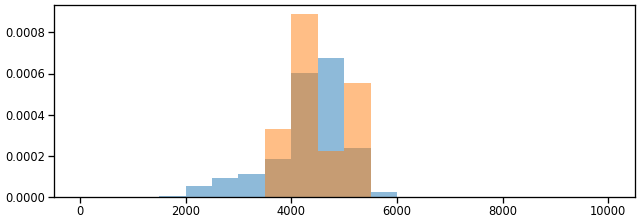

In [85]:
d = pd.DataFrame(dict(
    tally_moderate_hits=moderate_hit.sum(),
    sum_gene_ratio=strain_depth[moderate_hit].sum(),
)).assign(ratio=lambda x: x.sum_gene_ratio / x.tally_moderate_hits)

fig, ax = plt.subplots(figsize=(15, 5))
bins = np.linspace(0, 10000, num=21)
# sns.kdeplot(reference_hit.sum())
# sns.kdeplot(d.tally_moderate_hits)
# sns.kdeplot(d.tally_moderate_hits.loc[high_power_strain_list])


plt.hist(reference_copy_number.sum("gene_id"), bins=bins, density=True, alpha=0.5)
# plt.hist(d.sum_gene_ratio, bins=bins, density=True, alpha=0.5)
plt.hist(d.sum_gene_ratio.loc[high_power_strain_list], bins=bins, density=True, alpha=0.5)
None

In [46]:
samples_with_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() > 0.5)
samples_without_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() < 0.5)
len(samples_with_high_power_strains), len(samples_without_high_power_strains)

(410, 214)

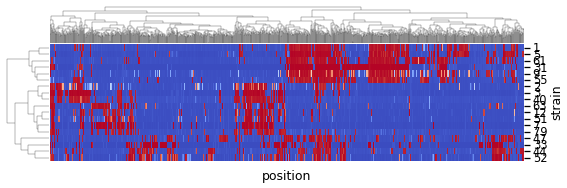

In [47]:
sf.plot.plot_genotype(
    fit.sel(strain=high_power_strain_list, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage("position"),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


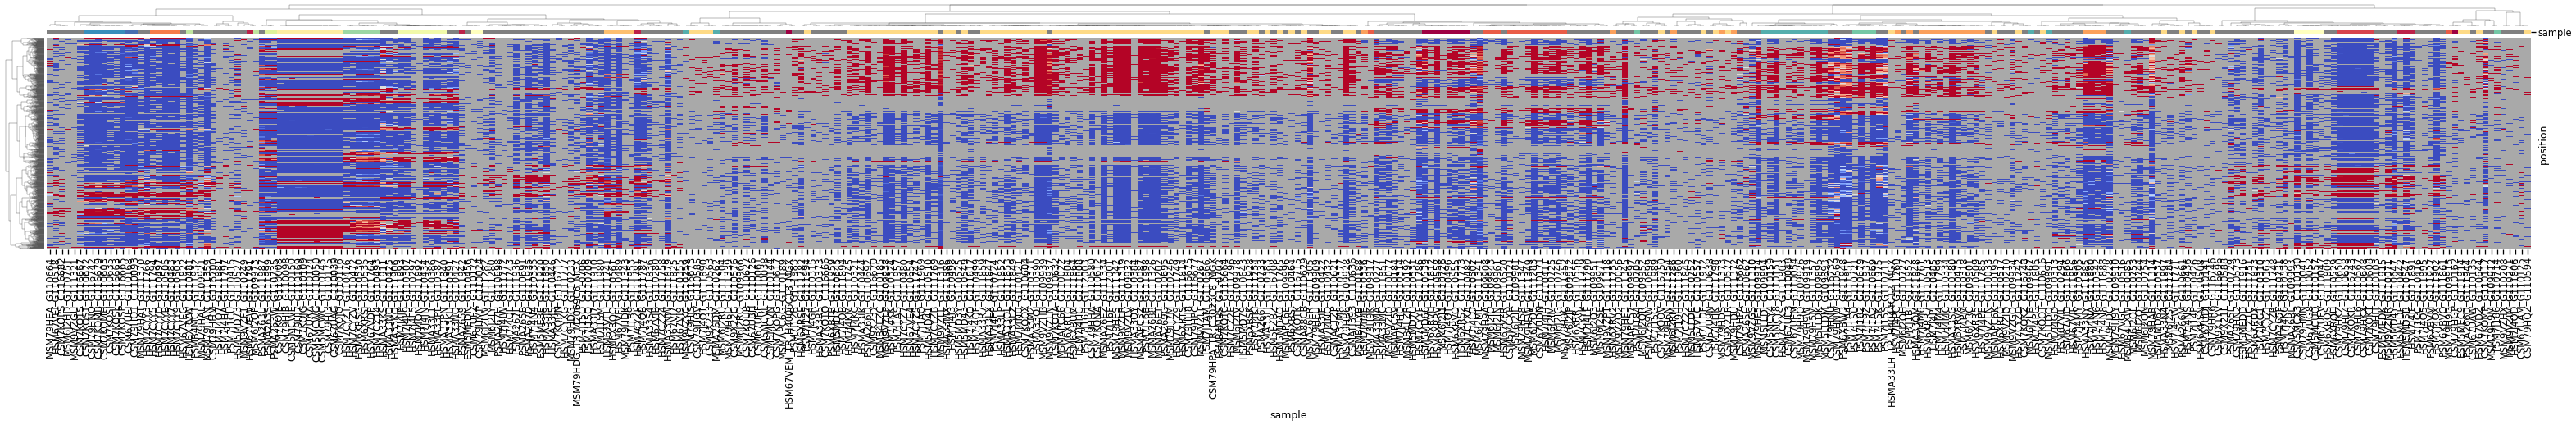

In [48]:
sf.plot.plot_metagenotype(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.metagenotype.linkage("position"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


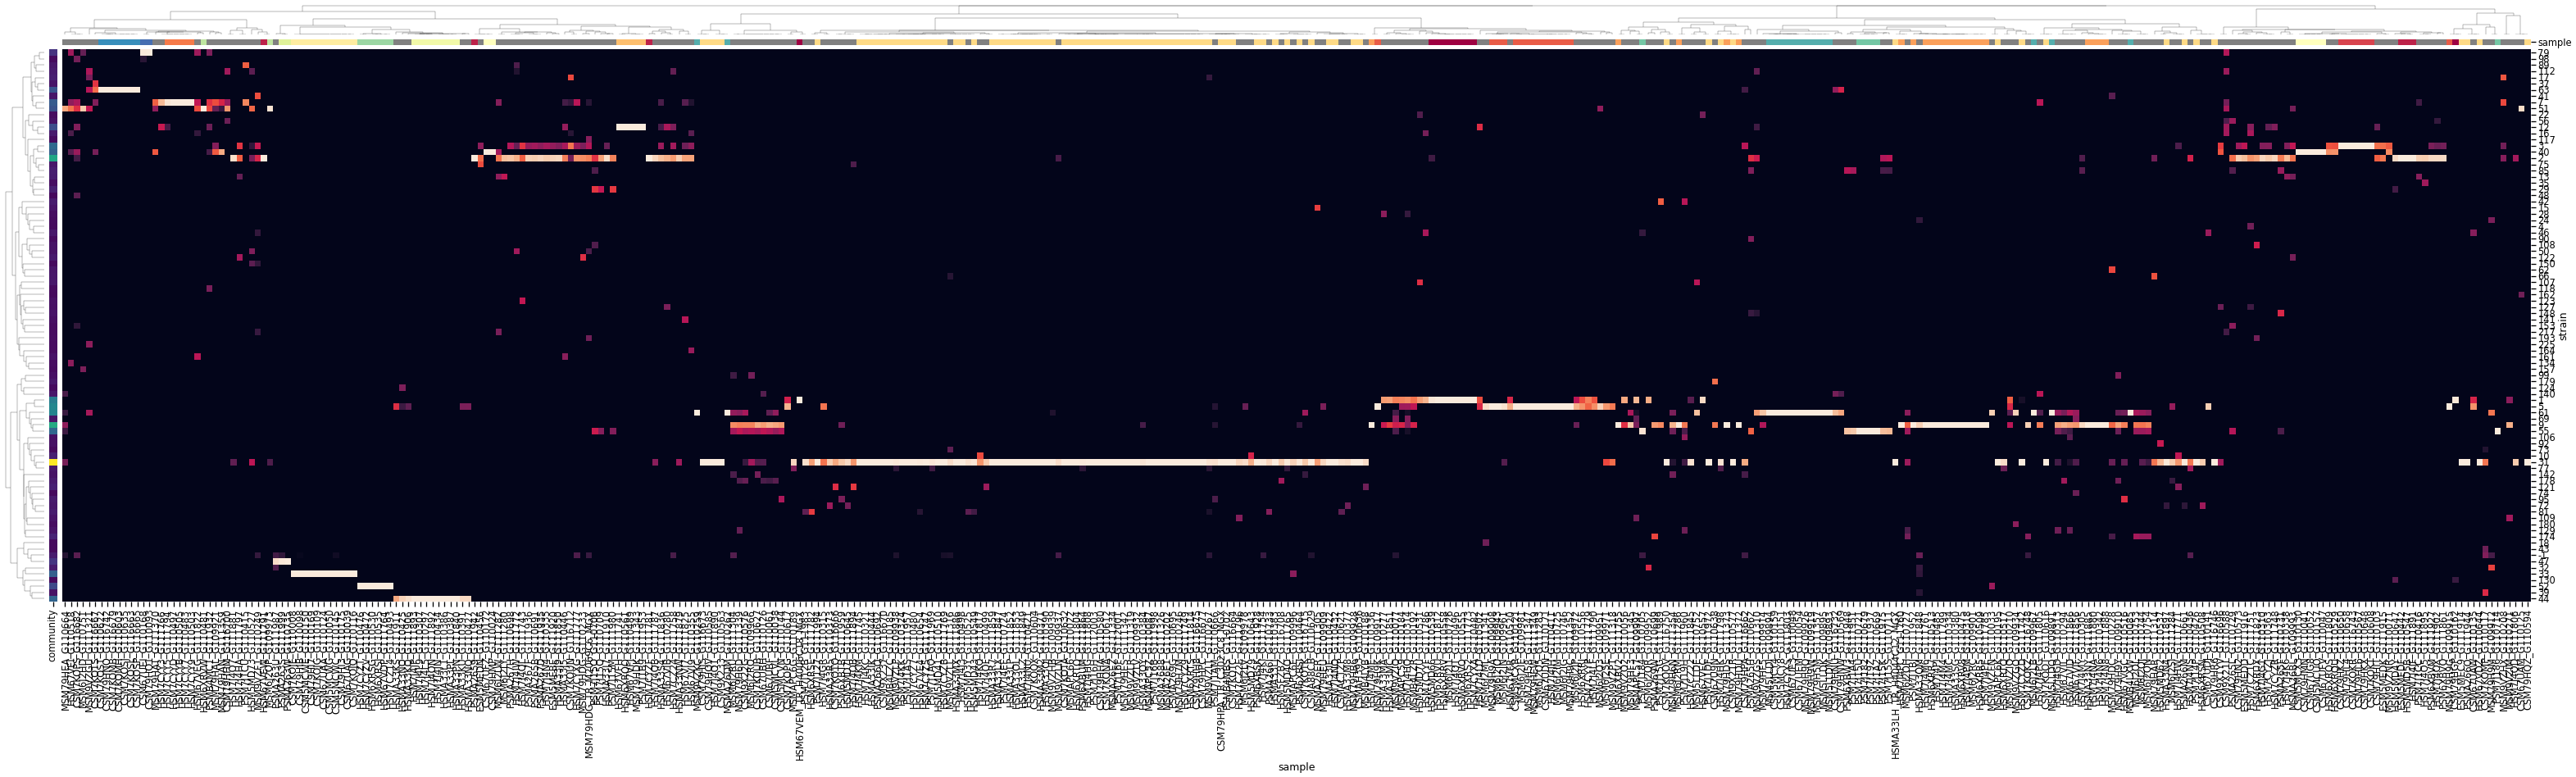

In [49]:
sf.plot.plot_community(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss).drop_low_abundance_strains(0.05),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

In [50]:
gene_cluster = pd.read_table(
    path["cluster_info"]
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    path["gene_annotations"],
    names=['locus_tag', 'ftype', 'length_bp', 'gene', 'EC_number', 'COG', 'product'],
    index_col='locus_tag',
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster[f'centroid_{centroid}'].unique()].join(gene_annotation)

In [51]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [52]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

/pollard/home/bsmith/.snakemake/conda/94b3294f3bfcd649af97bd849d201220_/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


16018 7617

tRNA modification                              73
Fatty acid biosynthesis                        60
Non-phosphorylated Entner-Doudoroff pathway    59
TCA cycle                                      55
Isoleucine, leucine, valine biosynthesis       51
Glycolysis                                     42
Aminoacyl-tRNA synthetases                     36
Arginine biosynthesis                          33
Pyrimidine salvage                             33
Pyrimidine degradation                         33
Name: pathway, dtype: int64

hypothetical protein                           8401
Vitamin B12 import ATP-binding protein BtuD      42
Tyrosine recombinase XerC                        41
Prophage integrase IntA                          40
Prophage integrase IntS                          23
putative protein                                 17
Outer membrane usher protein PapC                17
ISNCY family transposase ISRor2                  16
Protein RhsD                               

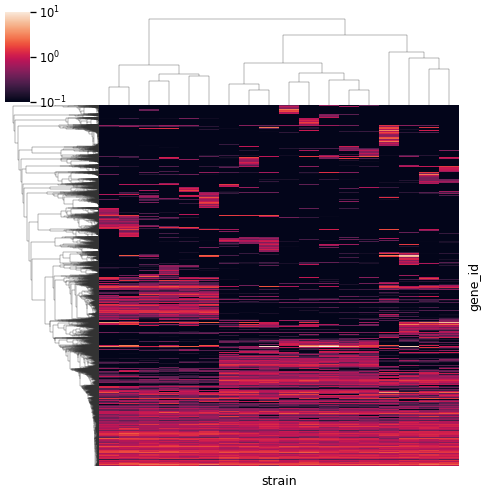

In [53]:
strain_list = high_power_strain_list
gene_list = idxwhere(moderate_hit[strain_list].sum(1) > 0)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/94b3294f3bfcd649af97bd849d201220_/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2320 1711

tRNA modification                           23
Fatty acid biosynthesis                     15
Aminoacyl-tRNA synthetases                  14
TCA cycle                                   13
Isoleucine, leucine, valine biosynthesis    11
23S rRNA modification                       11
Glycolysis                                  11
Aromatic amino acid biosynthesis            10
Heme biosynthesis                            9
Phospholipid biosynthesis                    9
Name: pathway, dtype: int64

hypothetical protein                              609
Vitamin B12 import ATP-binding protein BtuD        24
putative protein                                    7
HTH-type transcriptional repressor NanR             7
HTH-type transcriptional regulator DmlR             4
p-hydroxybenzoic acid efflux pump subunit AaeA      3
HTH-type transcriptional regulator HdfR             3
Membrane-bound lytic murein transglycosylase F      3
2-succinylbenzoate--CoA ligase                      3
Acet

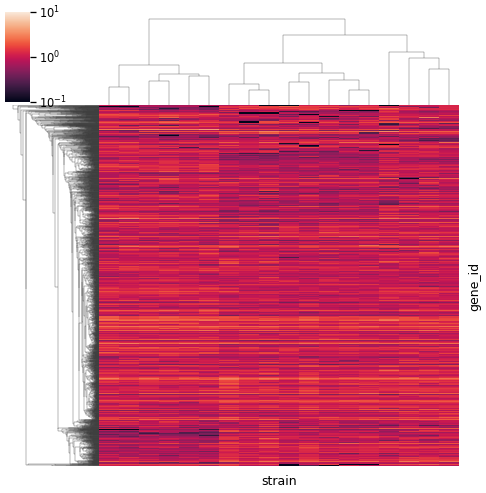

In [54]:
strain_list = high_power_strain_list
gene_list = idxwhere(moderate_hit[strain_list].mean(1) > 0.8)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/94b3294f3bfcd649af97bd849d201220_/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


11138 4354

Non-phosphorylated Entner-Doudoroff pathway    37
Isoleucine, leucine, valine biosynthesis       35
Fatty acid biosynthesis                        31
TCA cycle                                      26
Glycolysis                                     24
Pentose phosphate pathway                      17
Lysine biosynthesis                            17
Pyrimidine degradation                         17
Urea cycle                                     17
tRNA modification                              15
Name: pathway, dtype: int64

hypothetical protein                              6784
Tyrosine recombinase XerC                           40
Prophage integrase IntA                             40
Prophage integrase IntS                             23
Outer membrane usher protein PapC                   17
ISNCY family transposase ISRor2                     14
Protein RhsD                                        14
DNA-invertase hin                                   13
Cytoskeleton bundli

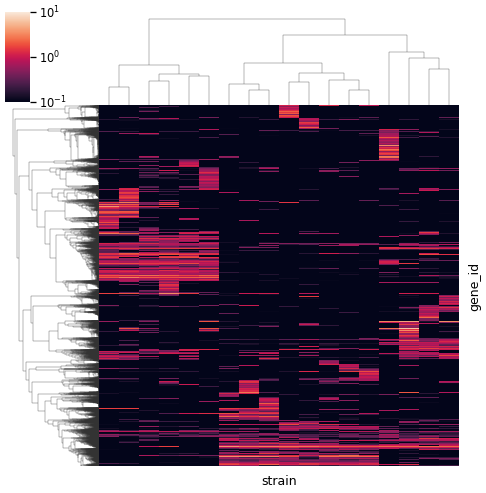

In [55]:
strain_list = high_power_strain_list
gene_list = idxwhere((moderate_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

# Broad strokes characterization of gene sets

## Phylogenetic conservation

SpearmanrResult(correlation=0.8952662404674786, pvalue=6.913971977204071e-55)

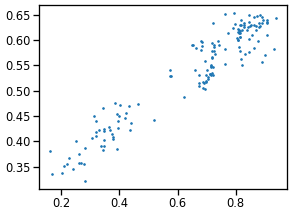

In [56]:
strain_list = high_power_strain_list
gene_list = moderate_hit.index

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = moderate_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

SpearmanrResult(correlation=0.9339558790023186, pvalue=2.31838933544532e-69)

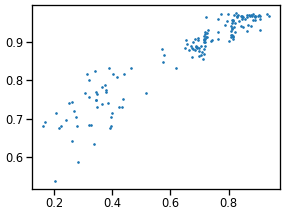

In [57]:
strain_list = high_power_strain_list
gene_list = idxwhere((moderate_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = moderate_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

In [58]:
tally_cog_category_reps = pd.merge(
    gene_meta.loc[idxwhere(moderate_hit[strain_list].any(1))].cog.value_counts().reset_index().rename(columns=dict(index='cog', cog='tally')),
    cog_x_category,
    on='cog'
).groupby('category').tally.sum().sort_values(ascending=False)
tally_cog_category_reps

/tmp/bsmith/ipykernel_33391/1414623036.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  gene_meta.loc[idxwhere(moderate_hit[strain_list].any(1))].cog.value_counts().reset_index().rename(columns=dict(index='cog', cog='tally')),


category
G    732
E    620
M    509
C    408
P    372
K    352
R    313
J    312
L    309
H    293
T    260
O    218
I    197
F    185
V    181
N    181
X    143
U    119
W    105
Q     96
S     69
D     69
A      4
Z      3
Name: tally, dtype: int64

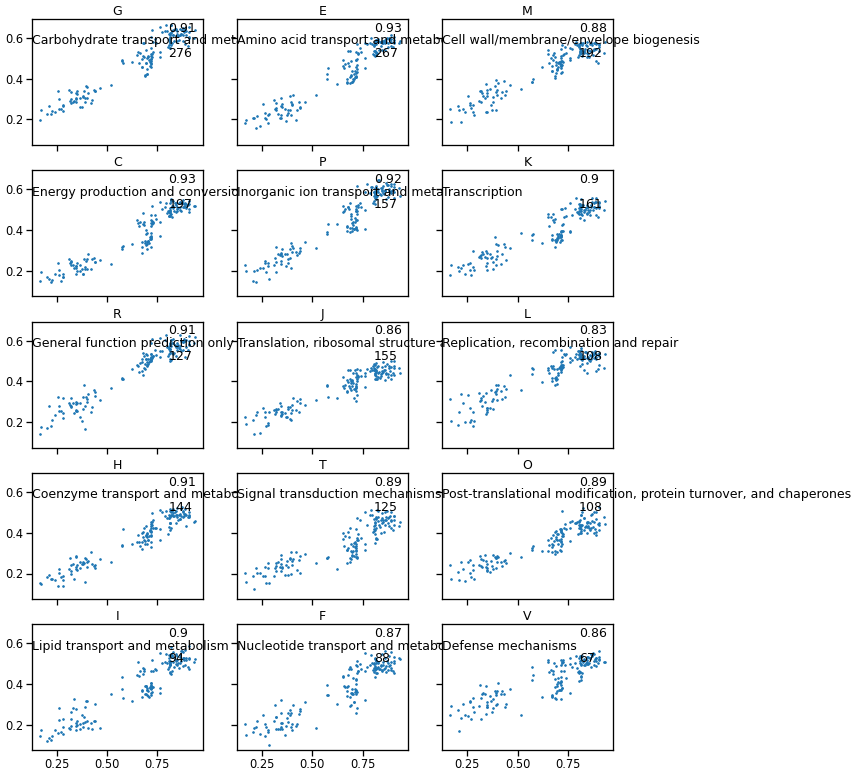

In [59]:
fig, axs = plt.subplots(5, 3, figsize=(15, 19), sharex=True, sharey=True)

for this_cog_category, ax in zip(tally_cog_category_reps.index, axs.flatten()):
    ax.set_title(this_cog_category)
    strain_list = high_power_strain_list
    cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
    gene_list = gene_meta.cog.isin(cog_list)

    x = moderate_hit.loc[gene_list, strain_list]
    fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

    gdist = fit.genotype.sel(strain=strain_list).pdist()

    d = pd.DataFrame(dict(
        genotype_distance=sp.spatial.distance.squareform(gdist),
        gene_content_distance=sp.spatial.distance.squareform(fdist)
    ))
    ax.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
    ax.annotate(np.round(sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)[0], 2), xy=(0.8, 0.9), xycoords='axes fraction')
    ax.annotate(int(x.mean(1).sum()), xy=(0.8, 0.7), xycoords='axes fraction')
    ax.annotate(cog_category.loc[this_cog_category].description, xy=(0.0, 0.8), xycoords='axes fraction')

# Enrichment Analysis in Reference Genomes

In [60]:
x = reference_hit
y = moderate_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

jac_cdist_inf_moderate = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [61]:
moderate_confidence_diff = pd.DataFrame(x[jac_cdist_inf_moderate.idxmin()].values * 2 - y[jac_cdist_inf_moderate.columns].values * 3, index=x.index, columns=y.columns).replace({-3: 'only_inf', -1: 'shared_genes', 0: 'both_lacking', 2: 'only_ref'})
moderate_confidence_diff.apply(lambda x: x.value_counts())[high_power_strain_list]

strain,1,2,3,5,7,9,12,31,33,40,44,47,51,52,55,61,63,79
both_lacking,196309,197075,196973,196351,197288,197398,197399,196987,196707,196578,196555,196328,197246,196855,196466,196394,196796,196861
only_inf,1646,1268,1296,1560,1480,1054,1136,1044,992,1686,1422,1806,1435,1338,1335,1597,1377,1364
only_ref,608,885,938,693,691,781,847,776,1033,774,625,610,700,787,612,744,881,926
shared_genes,3816,3151,3172,3775,2920,3146,2997,3572,3647,3341,3777,3635,2998,3399,3966,3644,3325,3228


In [62]:
x = reference_hit
y = high_confidence_hit

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

jac_cdist_inf_confident = pd.DataFrame(sp.spatial.distance.cdist(x.T, y.T, metric='jaccard'), index=x.columns, columns=y.columns)

In [63]:
high_confidence_diff = pd.DataFrame(x[jac_cdist_inf_confident.idxmin()].values * 2 - y[jac_cdist_inf_confident.columns].values * 3, index=x.index, columns=y.columns).replace({-3: 'only_inf', -1: 'shared_genes', 0: 'both_lacking', 2: 'only_ref'})
high_confidence_diff.apply(lambda x: x.value_counts())[high_power_strain_list]

strain,1,2,3,5,7,9,12,31,33,40,44,47,51,52,55,61,63,79
both_lacking,196483,197263,197127,196499,197460,197611,197548,197235,196835,196726,196778,196500,197406,197025,196645,196869,196988,197032
only_inf,1472,1189,1142,1412,1308,841,987,796,864,1538,1199,1634,1275,1168,1156,1389,1185,1193
only_ref,699,920,1062,806,790,904,995,985,1174,855,720,684,765,906,705,676,985,1027
shared_genes,3725,3007,3048,3662,2821,3023,2849,3363,3506,3260,3682,3561,2933,3280,3873,3445,3221,3127


PearsonRResult(statistic=0.8782610942202632, pvalue=0.0)

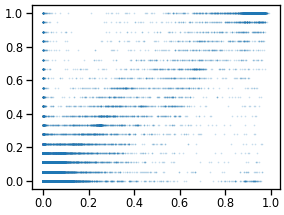

In [64]:
x = reference_hit.mean(1)
y = moderate_hit[high_power_strain_list].mean(1)

_all_genes = list(set(x.index) | set(y.index))

x = x.reindex(_all_genes, fill_value=False)
y = y.reindex(_all_genes, fill_value=False)

plt.scatter(x, y, alpha=0.2, s=1)
sp.stats.pearsonr(x, y)

In [65]:
ref_geno_pdist = ref_geno.pdist()
ref_hits_pdist = pd.DataFrame(
    sp.spatial.distance.squareform(sp.spatial.distance.pdist(reference_hit[ref_geno.strain].T, metric='jaccard')),
    index=ref_geno_pdist.index,
    columns=ref_geno_pdist.columns
)

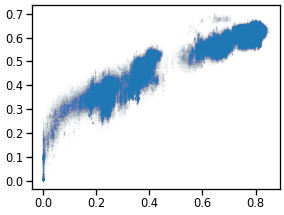

In [66]:
x = sp.spatial.distance.squareform(ref_geno_pdist)
y = sp.spatial.distance.squareform(ref_hits_pdist)
plt.scatter(x, y, alpha=0.01, s=1)
# plt.xscale('symlog', linthresh=1e-3, linscale=0.1)

In [67]:
geno_cdist_to_ref = pd.DataFrame(sf.math.genotype_cdist(fit.genotype.values, ref_geno.values), index=fit.strain, columns=ref_geno.strain)
geno_cdist_to_ref.shape

(147, 1000)

In [68]:
hits_cdist_to_ref = pd.DataFrame(sp.spatial.distance.cdist(moderate_hit.reindex(reference_hit.index, fill_value=False).T, reference_hit[ref_geno.strain].T, metric='jaccard'), index=moderate_hit.columns, columns=ref_geno.strain)
hits_cdist_to_ref.shape

(62, 1000)

In [69]:
_geno_cdist, _hits_cdist = align_indexes(geno_cdist_to_ref, hits_cdist_to_ref)

best_match_inf_geno = _geno_cdist.idxmin(1)
best_match_inf_geno_diss = {}
best_match_inf_hits_diss = {}
for s in _geno_cdist.index:
    best_match_inf_geno_diss[s] = _geno_cdist.loc[s, best_match_inf_geno[s]]
    best_match_inf_hits_diss[s] = _hits_cdist.loc[s, best_match_inf_geno[s]]

In [70]:
_geno_cdist, _hits_cdist = (ref_geno_pdist + np.eye(ref_geno_pdist.shape[0])), (ref_hits_pdist + np.eye(ref_hits_pdist.shape[0]))

best_match_ref_geno = _geno_cdist.idxmin(1)
# By adding 1 to the diagonal, we should make the best match NOT itself.
assert not (best_match_ref_geno.index.to_series() == best_match_ref_geno).any()

best_match_ref_geno_diss = {}
best_match_ref_hits_diss = {}
for s in _geno_cdist.index:
    best_match_ref_geno_diss[s] = _geno_cdist.loc[s, best_match_ref_geno[s]]
    best_match_ref_hits_diss[s] = _hits_cdist.loc[s, best_match_ref_geno[s]]

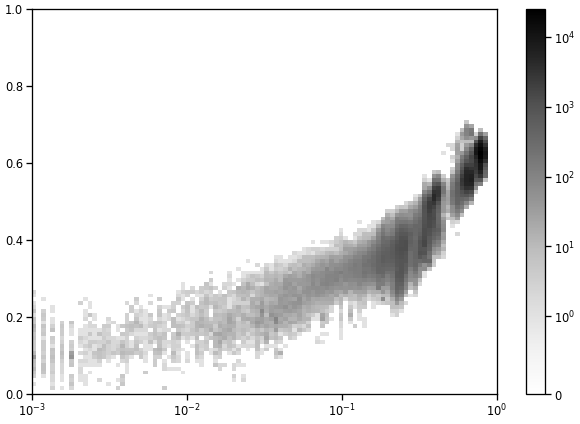

In [86]:
d_inf_to_ref = pd.DataFrame(dict(
    geno=best_match_inf_geno_diss,
    hits=best_match_inf_hits_diss,
    power_index=strain_meta.power_index,
))

d_ref_to_ref = pd.DataFrame(dict(
    geno=best_match_ref_geno_diss,
    hits=best_match_ref_hits_diss,
    power_index=strain_meta.power_index,
))

d_all_by_all = pd.DataFrame(dict(
    geno=sp.spatial.distance.squareform(ref_geno_pdist),
    hits=sp.spatial.distance.squareform(ref_hits_pdist),
))


fig = plt.figure(figsize=(15, 10))
xbins = np.logspace(-3, 0, num=101)
ybins = np.linspace(0, 1.0, num=101)
plt.hist2d('geno', 'hits', data=d_all_by_all, bins=(xbins, ybins), norm=mpl.colors.SymLogNorm(linthresh=1), cmap=mpl.cm.Greys)
plt.colorbar()
plt.xscale('symlog', linthresh=1e-3, linscale=0.2)
# plt.scatter('geno', 'hits', data=d_ref_to_ref, s=20)
# plt.scatter('geno', 'hits', data=d_inf_to_ref.loc[high_power_strain_list], s=20)


None

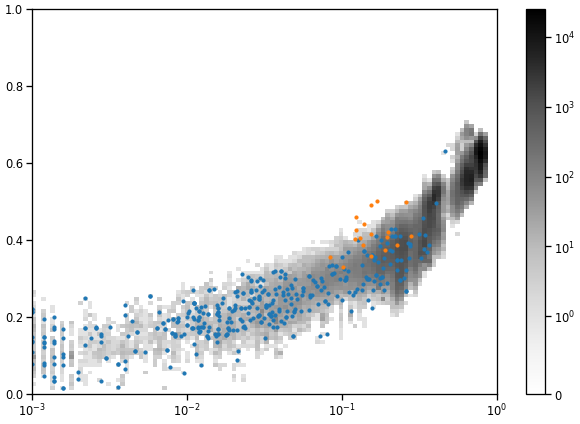

In [79]:
d_inf_to_ref = pd.DataFrame(dict(
    geno=best_match_inf_geno_diss,
    hits=best_match_inf_hits_diss,
    power_index=strain_meta.power_index,
))

d_ref_to_ref = pd.DataFrame(dict(
    geno=best_match_ref_geno_diss,
    hits=best_match_ref_hits_diss,
    power_index=strain_meta.power_index,
))

d_all_by_all = pd.DataFrame(dict(
    geno=sp.spatial.distance.squareform(ref_geno_pdist),
    hits=sp.spatial.distance.squareform(ref_hits_pdist),
))


fig = plt.figure(figsize=(15, 10))
xbins = np.logspace(-3, 0, num=101)
ybins = np.linspace(0, 1.0, num=101)
plt.hist2d('geno', 'hits', data=d_all_by_all, bins=(xbins, ybins), norm=mpl.colors.SymLogNorm(linthresh=1), cmap=mpl.cm.Greys)
plt.colorbar()
plt.xscale('symlog', linthresh=1e-3, linscale=0.2)
plt.scatter('geno', 'hits', data=d_ref_to_ref, s=20)
plt.scatter('geno', 'hits', data=d_inf_to_ref.loc[high_power_strain_list], s=20)


None

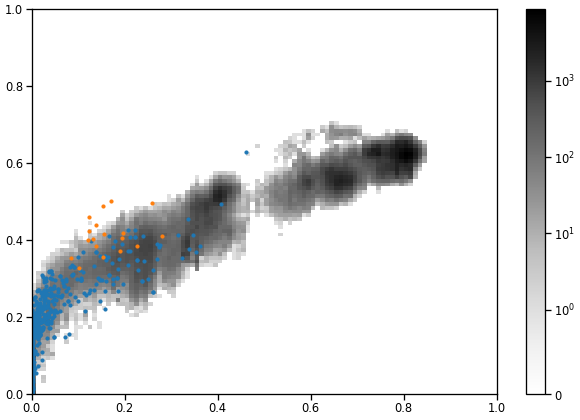

In [80]:
d_inf_to_ref = pd.DataFrame(dict(
    geno=best_match_inf_geno_diss,
    hits=best_match_inf_hits_diss,
    power_index=strain_meta.power_index,
))

d_ref_to_ref = pd.DataFrame(dict(
    geno=best_match_ref_geno_diss,
    hits=best_match_ref_hits_diss,
    power_index=strain_meta.power_index,
))

d_all_by_all = pd.DataFrame(dict(
    geno=sp.spatial.distance.squareform(ref_geno_pdist),
    hits=sp.spatial.distance.squareform(ref_hits_pdist),
))


fig = plt.figure(figsize=(15, 10))
xbins = np.linspace(0, 1.0, num=101)
ybins = np.linspace(0, 1.0, num=101)
plt.hist2d('geno', 'hits', data=d_all_by_all, bins=(xbins, ybins), norm=mpl.colors.SymLogNorm(linthresh=1), cmap=mpl.cm.Greys)
plt.colorbar()
plt.scatter('geno', 'hits', data=d_ref_to_ref, s=20)
plt.scatter('geno', 'hits', data=d_inf_to_ref.loc[high_power_strain_list], s=20)
None

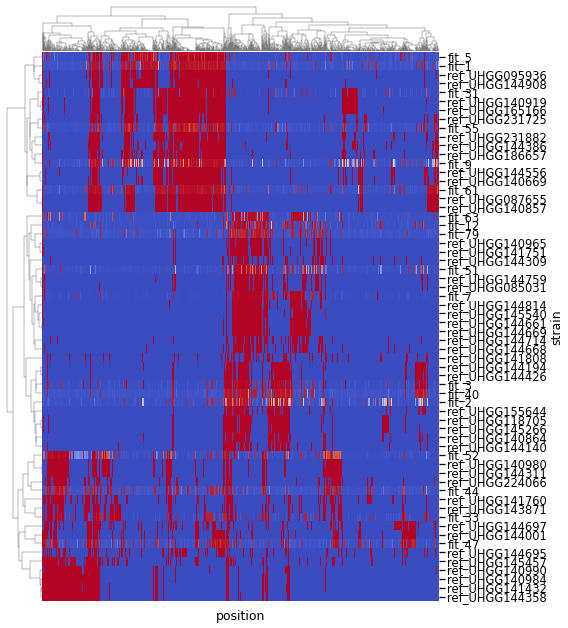

In [78]:
g = sf.Genotype.concat(dict(
    ref=ref_geno.sel(strain=best_match_inf_geno.unique()),
    fit=fit.genotype.sel(strain=high_power_strain_list),
), dim='strain')
sf.plot_genotype(g.sel(position=position_ss))